<a href="https://colab.research.google.com/github/SahilSuvarna1023/-Monte-Carlo-Football-Betting-Simulator/blob/main/Betting_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sample simulated results: [-1020.6999999999998, -744.8000000000002, -323.3000000000002, -413.10000000000036, -791.5, -703.5, -796.7999999999997, -486.5, -677.7999999999997, -611.5999999999999]


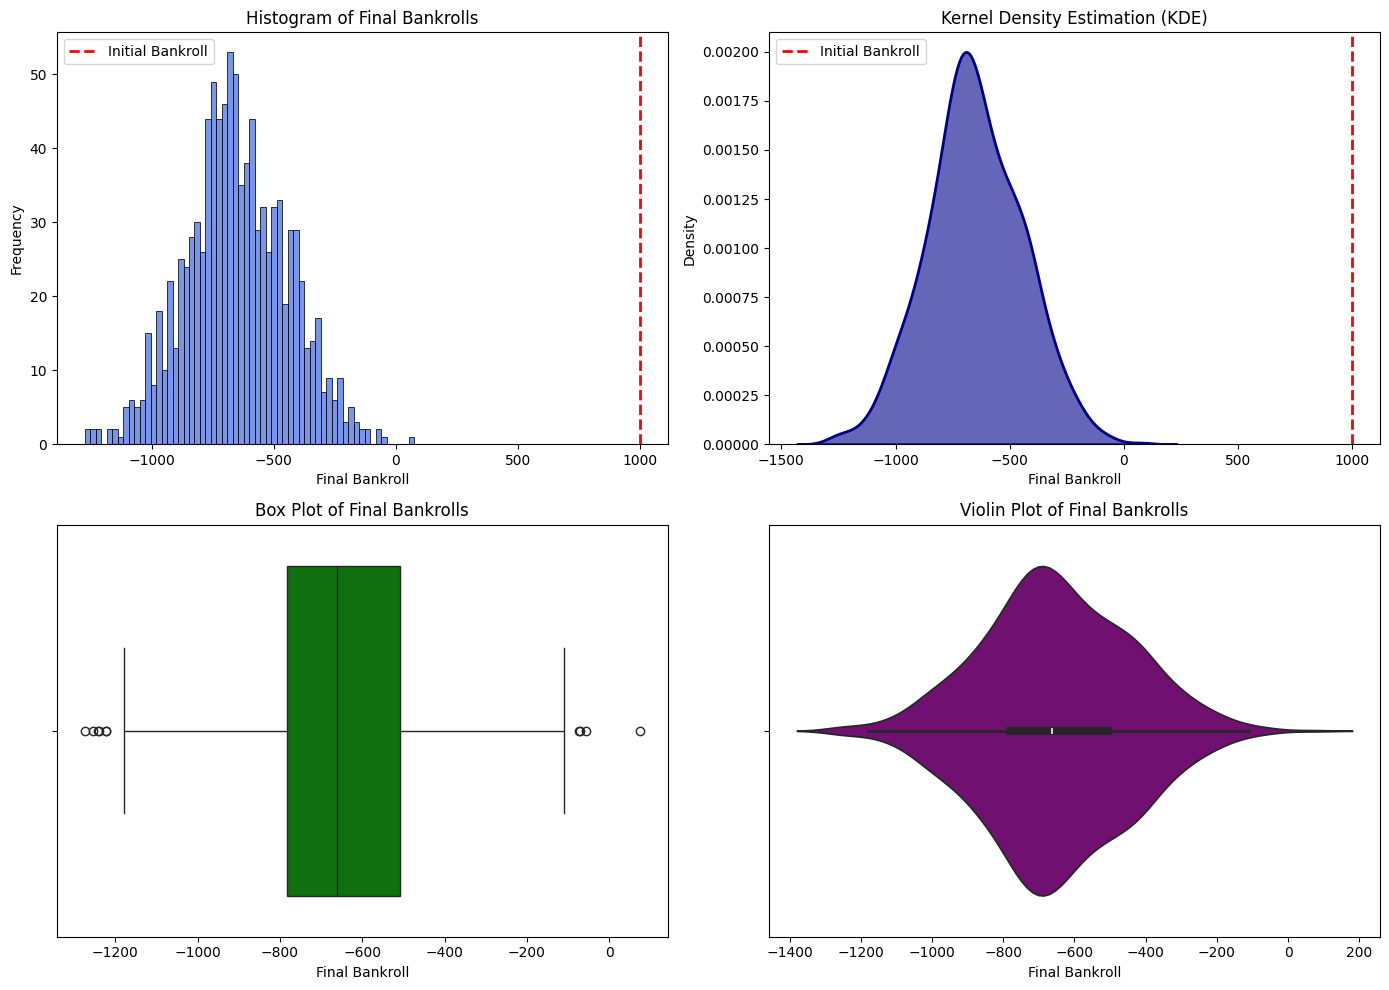

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

# Load and clean historical football betting data
file_path = "/content/E0.csv"  # Uploaded dataset
df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)

# Select relevant columns
df = df[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'B365H', 'B365D', 'B365A']]

# Drop rows with missing values
df = df.dropna()

# Convert odds columns to numeric
df[['B365H', 'B365D', 'B365A']] = df[['B365H', 'B365D', 'B365A']].apply(pd.to_numeric, errors='coerce')

# Drop any remaining NaN values after conversion
df = df.dropna()

# Simulated bankroll
initial_bankroll = 1000
num_simulations = 1000
stake = 10  # Flat stake betting

# Betting Strategy: Flat Betting (Vectorized for Speed)
def flat_betting(df, stake=10):
    bankroll = initial_bankroll
    bets = np.random.choice(['H', 'D', 'A'], size=len(df))
    win_conditions = [
        (bets == 'H') & (df['FTHG'] > df['FTAG']),
        (bets == 'D') & (df['FTHG'] == df['FTAG']),
        (bets == 'A') & (df['FTHG'] < df['FTAG'])
    ]
    odds = [df['B365H'], df['B365D'], df['B365A']]

    for condition, odd in zip(win_conditions, odds):
        bankroll += np.sum(condition * (stake * (odd - 1)))

    bankroll -= stake * len(df)  # Deduct lost bets
    return bankroll

# Monte Carlo Simulation using Parallel Processing
simulated_results = Parallel(n_jobs=-1)(delayed(flat_betting)(df, stake) for _ in range(num_simulations))

# Debugging: Print sample results to ensure non-empty data
print("Sample simulated results:", simulated_results[:10])

# Ensure results are valid before plotting
if len(simulated_results) > 0:
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Histogram
    sns.histplot(simulated_results, bins=60, kde=False, color='royalblue', edgecolor='black', alpha=0.7, ax=axes[0, 0])
    axes[0, 0].axvline(initial_bankroll, color='red', linestyle='dashed', linewidth=2, label='Initial Bankroll')
    axes[0, 0].set_title('Histogram of Final Bankrolls')
    axes[0, 0].set_xlabel('Final Bankroll')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()

    # KDE Plot
    sns.kdeplot(simulated_results, fill=True, color='darkblue', alpha=0.6, linewidth=2, ax=axes[0, 1])
    axes[0, 1].axvline(initial_bankroll, color='red', linestyle='dashed', linewidth=2, label='Initial Bankroll')
    axes[0, 1].set_title('Kernel Density Estimation (KDE)')
    axes[0, 1].set_xlabel('Final Bankroll')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()

    # Box Plot
    sns.boxplot(x=simulated_results, color='green', ax=axes[1, 0])
    axes[1, 0].set_title('Box Plot of Final Bankrolls')
    axes[1, 0].set_xlabel('Final Bankroll')

    # Violin Plot
    sns.violinplot(x=simulated_results, color='purple', ax=axes[1, 1])
    axes[1, 1].set_title('Violin Plot of Final Bankrolls')
    axes[1, 1].set_xlabel('Final Bankroll')

    # Adjust layout
    plt.tight_layout()
    plt.show()
else:
    print("Error: No valid simulation results to plot.")
